# Mode 6

In [4]:
!ln -s ../data/ ./
!ln -s ../out/ ./

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib import learn
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn import metrics
from __future__ import print_function

%matplotlib inline

In [3]:
import os
import keras
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools

import pandas as pd
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


# Load data for train

In [5]:
train = pd.read_csv('data/Train_data/dataset_rev4_train.csv')
#buffer datetime
buffer_datetime_train = train.datetime
#remove object
train = train.select_dtypes(exclude=['object'])
#replace misssing value
train.fillna(0,inplace=True)

# Load data for test

In [6]:
test = pd.read_csv('data/test_data/dataset_rev4_test.csv')
#buffer datetime
buffer_datetime_test = test.datetime
#remove object
test = test.select_dtypes(exclude=['object'])
#replace misssing value
test.fillna(0,inplace=True)

In [7]:
print('dimension of train:', train.shape)
print('dimension of test:', test.shape)

dimension of train: (131586, 6)
dimension of test: (16147, 5)


In [8]:
print("features:",list(train.columns))

features: ['I', 'T', 'UV', 'WS', 'RH', 'P']


# Remove outlier

In [9]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples = 100, random_state = 42)
clf.fit(train)
y_noano = clf.predict(train)
y_noano = pd.DataFrame(y_noano, columns = ['Top'])
y_noano[y_noano['Top'] == 1].index.values

train = train.iloc[y_noano[y_noano['Top'] == 1].index.values]
train.reset_index(drop = True, inplace = True)
print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
print("Number of rows without outliers:", train.shape[0])

Number of Outliers: 13159
Number of rows without outliers: 118427


# Normalize

In [10]:
import warnings
warnings.filterwarnings('ignore')

col_train = list(train.columns)
col_train_bis = list(train.columns)

col_train_bis.remove('P')

mat_train = np.matrix(train)
mat_test  = np.matrix(test)

mat_new = np.matrix(train.drop('P',axis = 1))
mat_y = np.array(train.P).reshape((118427,1))

prepro_y = MinMaxScaler()
prepro_y.fit(mat_y)

prepro = MinMaxScaler()
prepro.fit(mat_train)

prepro_test = MinMaxScaler()
prepro_test.fit(mat_new)

train = pd.DataFrame(prepro.transform(mat_train),columns = col_train)
test  = pd.DataFrame(prepro_test.transform(mat_test),columns = col_train_bis)

# Create training_set and prediction_set

In [11]:
# List of features
COLUMNS = col_train #column train (x train)
FEATURES = col_train_bis  #column train-label (x test)
LABEL = "P"

# Columns
feature_cols = FEATURES #(x test)

# Training set and Prediction set with the features to predict
training_set = train[COLUMNS] #column train (x train)
prediction_set = train.P # column P

In [12]:
print(type(training_set))
print(type(prediction_set))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


# Create x_train and Test 

In [13]:
x_train, x_test, y_train, y_test = cross_validation.train_test_split(training_set[FEATURES] , prediction_set, test_size=0.33, random_state=42)

In [14]:
print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [15]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(79346, 5)
(39081, 5)
(79346,)
(39081,)


# Create training_set

In [16]:
y_train = pd.DataFrame(y_train, columns = [LABEL])
training_set = pd.DataFrame(x_train, columns = FEATURES).merge(y_train, left_index = True, right_index = True)
training_sub = training_set[col_train]

In [17]:
print(y_train.shape)

(79346, 1)


# Create testing_set

In [18]:
y_test = pd.DataFrame(y_test, columns = [LABEL])
testing_set = pd.DataFrame(x_test, columns = FEATURES).merge(y_test, left_index = True, right_index = True)

In [19]:
print(y_test.shape)

(39081, 1)


In [20]:
training_set.head(1)

,I,T,UV,WS,RH,P
108496,0.034862,0.452675,0.019608,0.279006,0.619369,0.016393


In [21]:
print( "Dimension of x_test = ", x_test.shape )
print( "Dimension of y_test = ", y_test.shape )
print( "Dimension of x_train = ", x_train.shape )
print( "Dimension of y_train = ", y_train.shape )

Dimension of x_test =  (39081, 5)
Dimension of y_test =  (39081, 1)
Dimension of x_train =  (79346, 5)
Dimension of y_train =  (79346, 1)


# We verify that we have 5 features...

In [22]:
numFeatures =  x_train.shape[1] 

print( "number of features = ", numFeatures )

number of features =  5


<h2>Input & Output Place-Holders</h2>
Define 2 place holders to the graph, one for the inputs one for the outputs...

In [23]:
with tf.name_scope("IO"):
    inputs = tf.placeholder(tf.float32, [None, numFeatures], name="X")
    outputs = tf.placeholder(tf.float32, [None, 1], name="Yhat")

<h2>Define the Coeffs for the Layers</h2>
For each layer the input vector will be multiplied by a matrix $h$ of dim $n$ x $m$, where $n$ is the dimension of the input vector and $m$ the dimention of the output vector.   Then a bias vector of dimension $m$ is added to the product.

In [24]:
with tf.name_scope("LAYER"):
    # network architecture
    Layers = [numFeatures, 52, 104, 52, 52, 52, 1]
    h = []
    b = []
    for i in range( 1, len( Layers ) ):
        h.append( tf.Variable(tf.random_normal([Layers[i-1], Layers[i]], 0, 0.1, dtype=tf.float32), name="h%d" % i ) )
        b.append( tf.Variable(tf.random_normal([Layers[i]], 0, 0.1, dtype=tf.float32 ), name="b%d" % i ) )
   
    dropout = 0.990                           # Dropout, probability to keep units
    keep_prob = tf.placeholder(tf.float32)   # dropout (keep probability)

<h2>Define the Layer operations as a Python funtion</h2>

In [25]:
def model( inputs, h, b ):
    lastY = inputs
    for i, (hi, bi) in enumerate( zip( h, b ) ):
        y =  tf.add( tf.matmul( lastY, h[i]), b[i] )    
        
        if i==len(h)-1:
            return y
        
        lastY =  tf.nn.relu( y )
        lastY =  tf.nn.dropout( lastY, dropout )

<h2>Define the operations that are performed</h2>
We define what happens to the inputs (x), when they are provided, and what we do with 
the outputs of the layers (compare them to the y values), and the type of minimization 
that must be done.

In [26]:
with tf.name_scope("train"):

    learning_rate = 0.250
    #yout = model2( inputs, [h1, b1, h2, b2, h3, b3, hout, bout] )
    yout = model( inputs, h, b )
    
    cost_op = tf.reduce_mean( tf.pow( yout - outputs, 2 ))
    #cost_op = tf.reduce_sum( tf.pow( yout - outputs, 2 ))
    #cost_op =  tf.reduce_mean(-tf.reduce_sum( yout * tf.log( outputs ) ) )

    #train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)
    #train_op = tf.train.AdamOptimizer( learning_rate=learning_rate ).minimize( cost_op )
    train_op = tf.train.AdagradOptimizer( learning_rate=learning_rate ).minimize( cost_op )

<h2>Train the Model</h2>
We are now ready to go through many sessions, and in each one train the model.  Here we train on the whole x-train and y-train data, rather than batching into smaller groups.

In [27]:
# define variables/constants that control the training
epoch       = 0          # counter for number of rounds training network
last_cost   = 0          # keep track of last cost to measure difference
max_epochs  = 40000      # total number of training sessions
tolerance   = 1e-6       # we stop when diff in costs less than that
batch_size  = 50         # we batch the data in groups of this size
num_samples = y_train.shape[0]                  # number of samples in training set
num_batches = int( num_samples / batch_size )   # compute number of batches, given 
                                                # batch size
    

print( "batch size = ", batch_size )
print( "test length= ", num_samples )
print( "number batches = ", num_batches )
print( "--- Beginning Training ---" )

sess = tf.Session() # Create TensorFlow session
with sess.as_default():
    
    # initialize the variables
    init = tf.initialize_all_variables()
    sess.run(init)
    
    # start training until we stop, either because we've reached the max
    # number of epochs, or successive errors are close enough to each other
    # (less than tolerance)
    
    costs = []
    epochs= []
    while True:
        # Do the training
        cost = 0
        for n in range(  num_batches ):
            batch_x = x_train[ n*batch_size : (n+1)*batch_size ]
            batch_y = y_train[ n*batch_size : (n+1)*batch_size ]
            sess.run( train_op, feed_dict={inputs: batch_x, outputs: batch_y} )
            c = sess.run(cost_op, feed_dict={inputs: batch_x, outputs: batch_y} )
            cost += c
        cost /= num_batches
        
        costs.append( cost )
        epochs.append( epoch )
            
        # Update the user every 1000 epochs
        if epoch % 1000==0:
            print( "Epoch: %d - Error diff: %1.8f" %(epoch, cost) )
            
            # time to stop?
            if epoch > max_epochs  or abs(last_cost - cost) < tolerance:
                print( "--- STOPPING ---" )
                break
            last_cost = cost
            
        epoch += 1
    
    # we're done...
    # print some statistics...
    
    print( "Test Cost =", sess.run(cost_op, feed_dict={inputs: x_test, outputs: y_test}) )

    # compute the predicted output for test_x
    pred_y = sess.run( yout, feed_dict={inputs: x_test, outputs: y_test} )
    
    print( "\nA few predictions versus real data from test set\nPrediction\nreal\tpredicted" )
    for (y, yHat ) in list(zip( y_test, pred_y ))[0:10]:
        print( "%1.1f\t%1.1f" % (y, yHat ) )

batch size =  50
test length=  79346
number batches =  1586
--- Beginning Training ---
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Epoch: 0 - Error diff: 0.00600421
Epoch: 1000 - Error diff: 0.00283710
Epoch: 2000 - Error diff: 0.00259905
Epoch: 3000 - Error diff: 0.00248070
Epoch: 4000 - Error diff: 0.00237886
Epoch: 5000 - Error diff: 0.00233899
Epoch: 6000 - Error diff: 0.00228040
Epoch: 7000 - Error diff: 0.00224871
Epoch: 8000 - Error diff: 0.00221398
Epoch: 9000 - Error diff: 0.00218586
Epoch: 10000 - Error diff: 0.00216125
Epoch: 11000 - Error diff: 0.00215027
Epoch: 12000 - Error diff: 0.00213382
Epoch: 13000 - Error diff: 0.00214490
Epoch: 14000 - Error diff: 0.00212426
Epoch: 15000 - Error diff: 0.00211279
Epoch: 16000 - Error diff: 0.00210903
Epoch: 17000 - Error diff: 0.00211775
Epoch: 18000 - Error diff: 0.00211729
--- STOPPING ---
Test Cost = 0.0039168764

A few predictions versus real data from test set
Prediction
real	predicted


TypeError: must be real number, not str

In [34]:
print( "\nA few predictions versus real data from test set\nPrediction\nreal\tpredicted" )
for (y, yHat ) in list(zip( y_test.values, pred_y ))[0:10]:
        print( "%1.1f\t%1.1f" % (y, yHat ) )


A few predictions versus real data from test set
Prediction
real	predicted
0.4	0.4
0.7	0.7
0.6	0.6
0.0	0.0
0.1	0.1
0.2	0.2
0.3	0.3
0.6	0.5
0.4	0.5
0.6	0.5


In [35]:
r2 =  metrics.r2_score(y_test, pred_y) 
print( "mean squared error = ", metrics.mean_squared_error(y_test, pred_y))
print( "r2 score (coef determination) = ", metrics.r2_score(y_test, pred_y))

mean squared error =  0.003940887286311818
r2 score (coef determination) =  0.9227213396547904


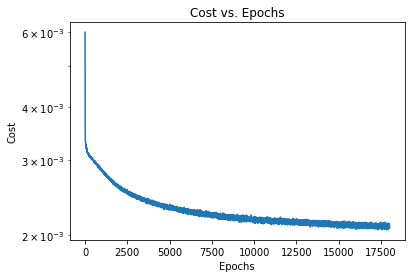

In [38]:
fig = plt.figure()
plt.semilogy( epochs, costs )
plt.xlabel( "Epochs" )
plt.ylabel( "Cost" )
plt.title( "Cost vs. Epochs")
plt.show()
fig.savefig('CostVsEpochs.png', bbox_inches='tight')